In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [3]:
# sorts amino acids couples according to the distance df

def get_sorted_substitutions(distances_df):
    substitutions = []
    amino_acids = distances_df.index

    for source_acid in amino_acids:
        for target_acid in amino_acids:
            if source_acid != target_acid:
                distance = distances_df.loc[source_acid, target_acid]
                substitutions.append((source_acid, target_acid, distance))
# 
    return sorted(substitutions, key=lambda x: x[2])

In [4]:
def seq_to_dict(seq):
    result_dict = {}
    for idx, char in enumerate(seq):
        if char in result_dict:
            result_dict[char].append(idx)
        else:
            result_dict[char] = [idx]
    return result_dict


In [1]:
from tqdm import tqdm

def find_couples(sequences_set, sorted_amino, max_neighbors=1):
    couples = {}
    total_iterations = len(sequences_set)
    for seq in tqdm(sequences_set, desc="Progress", unit=" sequence"):
        dict_seq = seq_to_dict(seq)
        couples[seq] = []
        flag = 0
        for sub in sorted_amino:
            if sub[0] not in dict_seq:
                continue

            if flag < max_neighbors:
                for occ in dict_seq[sub[0]]:
                    seq_to_search = seq[:occ] + sub[1] + seq[occ + 1:]
                    distance = sub[2]
                    if seq_to_search in sequences_set:
                        couples[seq].append([seq_to_search, distance])
                        flag += 1
                        if flag < max_neighbors:
                            break
            else:
                break

    return couples


In [5]:
distances_csv = "../distance_matrix.csv"
distances_df = pd.read_csv(distances_csv, index_col=0)

sorted_amino = get_sorted_substitutions(distances_df)

In [6]:
# read distance matrix

sequences_csv = '../files/forchen_F_26L.csv'
sequences_header = "cdr3_amino_acid"

sequences_csv = '../files/for_chen_B.csv'
sequences_header = "CDR3.aa"

# sequences_csv = "../random_sequences.csv"
# sequences_header = "sequences"

sequences_df = pd.read_csv(sequences_csv)

sequences_set = set(sequences_df[sequences_header].unique())

# sequences_set.add("CASSLALAGGTDTQYI")
# sequences_set.add("CASSLALAGGTDTQYC")

sorted_amino = get_sorted_substitutions(distances_df)
couples = find_couples(sequences_set, sorted_amino, max_neighbors=1)


Progress: 100%|██████████| 37399/37399 [00:05<00:00, 7231.22 sequence/s]


In [32]:
import json

with open("../couples.json") as json_file:
    couples = json.load(json_file)


In [7]:
# Create a graph
G = nx.Graph()

# Add edges to the graph based on the dictionary
for node, neighbors in couples.items():
    for neighbor, weight in neighbors:
        G.add_edge(node, neighbor, weight=weight)

In [8]:
def get_edges_colors(G):
    # color edegs according to their connection, the greener the color the stringer the connection
    # Create a colormap ranging from red to green
    cmap = plt.cm.RdYlGn_r

    # Find the maximum and minimum weights
    max_weight = max([d['weight'] for _, _, d in G.edges(data=True)])
    min_weight = min([d['weight'] for _, _, d in G.edges(data=True)])

    # Normalize the weights
    norm = mcolors.Normalize(vmin=min_weight, vmax=max_weight)

    # Create a color mapping based on edge weights
    edge_colors = [cmap(norm(d['weight'])) for _, _, d in G.edges(data=True)]
    return edge_colors
    

### Visualize the whole graph

In [ ]:

edge_colors = get_edges_colors(G)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k=0.3, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('sequence_graph_highest_degree_with_connections.png')
plt.show()

### Highest degree node

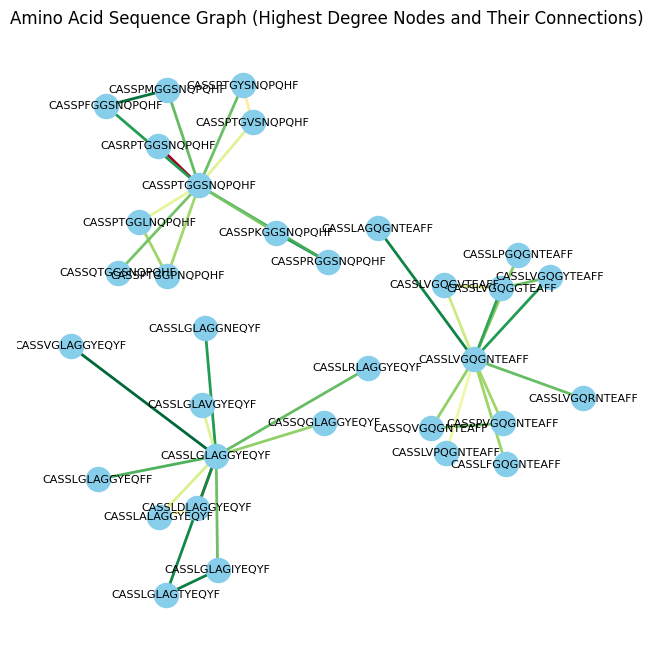

In [9]:
max_degree = max(dict(G.degree()).values())
highest_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree == max_degree]

# Create a subgraph with only the highest degree nodes and their neighbors
highest_degree_neighbors = set()
for node in highest_degree_nodes:
    highest_degree_neighbors.update(G.neighbors(node))
highest_degree_neighbors.update(highest_degree_nodes)
H = G.subgraph(highest_degree_neighbors)

edge_colors = get_edges_colors(H)

# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Highest Degree Nodes and Their Connections)')
plt.axis('off')  # Turn off axis
plt.savefig('sequence_graph_highest_degree_with_connections.png')
plt.show()


### Longest path

In [34]:
# Find the longest path in the graph
longest_path = max(nx.all_pairs_shortest_path_length(G), key=lambda x: max(x[1].values()))

# Extract nodes involved in the longest path
longest_path_nodes = longest_path[1].keys()

# Create a subgraph with nodes involved in the longest path
H = G.subgraph(longest_path_nodes)

edge_colors = get_edges_colors(H)


# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.3, iterations=20)
nx.draw_networkx_nodes(H, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title('Amino Acid Sequence Graph (Longest Connection)')
plt.axis('off')  # Turn off axis
plt.savefig('sequence_graph_longest_connection.png')
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f408a7f8d60>>
Traceback (most recent call last):
  File "/home/chen/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
